In [5]:
import numpy as np
import pandas as pd
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
import pyximport
pyximport.install(language_level=3)
import life

In [16]:
def create_model():
    nn = Sequential()
    nn.add(Dense(400, input_shape=(400,), activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
    return nn

In [17]:
es = EarlyStopping(monitor='loss', patience=6, min_delta=0.01)
check = ModelCheckpoint('weights.{epoch:02d}-{acc:.2f}.hdf5', monitor='acc', save_best_only=True)

In [18]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_12 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_13 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_14 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_15 (Dense)             (None, 400)               160400    
Total params: 802,000
Trainable params: 802,000
Non-trainable params: 0
_________________________________________________________________


In [19]:
NROW, NCOL = 20, 20

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples
    
    @return: (end_frames, start_frames)
    """
    batch = np.split(np.random.binomial(1, 0.5, (NROW * n, NCOL)).astype('uint8'), n)
    Yy = [life.make_move(state, 5) for state in batch]
    Xx = [life.make_move(state, 1) for state in Yy]
    Y = np.array([y.ravel() for y in Yy])
    X = np.array([x.ravel() for x in Xx])
    return X, Y
    

def data_generator(delta=1, batch_size=32):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        batch = np.split(np.random.binomial(1, 0.5, (NROW * batch_size, NCOL)).astype('uint8'), batch_size)
        Yy = [life.make_move(state, 5) for state in batch]
        Xx = [life.make_move(state, delta) for state in Yy]

        Y = np.array([y.ravel() for y in Yy])
        X = np.array([x.ravel() for x in Xx])
        yield X, Y

In [22]:
model.fit_generator(data_generator(), steps_per_epoch=500, epochs=20, verbose=2, callbacks=[es, check])

Epoch 1/20
 - 4s - loss: 0.4142 - acc: 0.7908 - mean_absolute_error: 0.2702
Epoch 2/20
 - 4s - loss: 0.4139 - acc: 0.7909 - mean_absolute_error: 0.2700
Epoch 3/20
 - 4s - loss: 0.4132 - acc: 0.7913 - mean_absolute_error: 0.2695
Epoch 4/20
 - 4s - loss: 0.4128 - acc: 0.7917 - mean_absolute_error: 0.2691
Epoch 5/20
 - 4s - loss: 0.4125 - acc: 0.7918 - mean_absolute_error: 0.2690
Epoch 6/20
 - 4s - loss: 0.4116 - acc: 0.7925 - mean_absolute_error: 0.2683
Epoch 7/20
 - 4s - loss: 0.4109 - acc: 0.7928 - mean_absolute_error: 0.2679


In [26]:
train_df = pd.read_csv('resources/train.csv', index_col=0)

In [28]:
from viz import show_field

In [30]:
start = train_df.iloc[1, 1:401].values.reshape((20, 20))
stop = train_df.iloc[1, 401:].values.reshape((20, 20))
delta = train_df.iloc[1, 0]

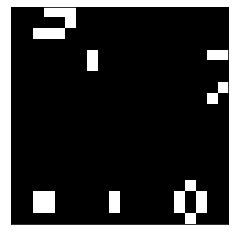

In [31]:
show_field(start)

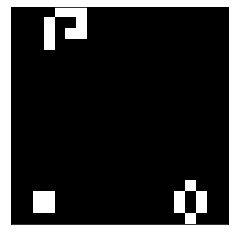

In [32]:
show_field(stop)

In [33]:
train_pred = model.predict(train_df.iloc[:, 401:]).round(0).astype('uint8')

In [36]:
v = (train_pred == train_df.iloc[:, 1:401]).values

In [37]:
v.sum() / (v.shape[0] * v.shape[1])

0.85615925

In [40]:
single_delta = train_df[train_df.delta == 1]
pred = model.predict(single_delta.iloc[:, 401:]).round(0).astype('uint8')
v = (pred == single_delta.iloc[:, 1:401]).values
v.sum() / (v.shape[0] * v.shape[1])

0.8681819331983806

In [41]:
v = (np.zeros_like(pred) == single_delta.iloc[:, 1:401]).values
v.sum() / (v.shape[0] * v.shape[1])

0.8549888663967611

In [23]:
test_df = pd.read_csv('resources/test.csv', index_col=0)

In [24]:
submit_df = pd.DataFrame(model.predict(test_df.iloc[:, 1:]).round(0).astype('uint8'), 
                         index=test_df.index, columns=['start.' + str(_) for _ in range(1, 401)])

In [25]:
submit_df.to_csv('nn_submit_v2.csv')